# Model Prototyping

After we has resampled the data, we can start prototyping our model. We will use CatBoost, a gradient boosting library that is particularly effective for tabular data.


In [1]:
import pandas as pd

from stroke_prediction.config import PROCESSED_DATA_DIR

train_data = pd.read_parquet(PROCESSED_DATA_DIR / "train-stroke-data-resampled.parquet")
val_data = pd.read_parquet(PROCESSED_DATA_DIR / "val-stroke-data.parquet")
test_data = pd.read_parquet(PROCESSED_DATA_DIR / "test-stroke-data.parquet")

2025-05-27 20:52:53.489 | INFO     | stroke_prediction.config:<module>:11 - PROJ_ROOT path is: E:\Projects\stroke-prediction-api


In [41]:
from catboost import Pool

X_train = train_data.drop(columns=["stroke"])
y_train = train_data["stroke"]

X_val = val_data.drop(columns=["stroke"])
y_val = val_data["stroke"]

X_test = test_data.drop(columns=["stroke"])
y_test = test_data["stroke"]

train_pool = Pool(
    data=X_train,
    label=y_train,
)
val_pool = Pool(data=X_val, label=y_val)
test_pool = Pool(data=X_test, label=y_test)

We will log the model parameters and the model itself using MLFlows, which allows us to track our experiments and compare different runs.


In [3]:
import mlflow

from stroke_prediction.util import get_or_create_experiment

mlflow.set_tracking_uri("https://mlflow.spikehub.win/")
experiment_id = get_or_create_experiment("Catboost Tuning")

After loading the data, we will tuning the model using optuna with TPE Sampler. The objective function will be defined to maximize the F1 score, which is a good metric for imbalanced datasets.


In [ ]:
import optuna
from catboost import CatBoostClassifier
from optuna.integration import CatBoostPruningCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


def objective(trial: optuna.Trial) -> float:
    with mlflow.start_run(nested=True):
        params = {
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
            "depth": trial.suggest_int("max_depth", 4, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
            "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
            ),
            "eval_metric": "F1",
            "auto_class_weights": "Balanced",
            "random_seed": 42,
        }

        if params["bootstrap_type"] == "Bayesian":
            params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif params["bootstrap_type"] == "Bernoulli":
            params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

        model = CatBoostClassifier(**params, verbose=0)

        pruning_callback = CatBoostPruningCallback(trial, "F1")

        model.fit(
            train_pool,
            eval_set=val_pool,
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
            verbose=0,
        )

        pruning_callback.check_pruned()

        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)

        mlflow.log_params(params)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("accuracy", accuracy)

    return f1

In [ ]:
run_name = "First Tuning"

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
    )
    study.optimize(objective, n_trials=300)

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_f1", study.best_value)


## Final Training

Training the model with the best hyperparameters found during the tuning phase. We will use the entire training set for this final training step.


In [4]:
best_run = mlflow.get_run("a7f14a0dfabd4189a20df0f7d236615e")
mlflow_best_params = best_run.data.params

best_params = {
    "colsample_bylevel": float(mlflow_best_params["colsample_bylevel"]),
    "depth": int(mlflow_best_params["max_depth"]),
    "l2_leaf_reg": float(mlflow_best_params["l2_leaf_reg"]),
    "boosting_type": mlflow_best_params["boosting_type"],
    "bootstrap_type": mlflow_best_params["bootstrap_type"],
    "eval_metric": "F1",
    "auto_class_weights": "Balanced",
    "random_seed": 42,
}

In [5]:
best_params

{'colsample_bylevel': 0.09512938089563211,
 'depth': 8,
 'l2_leaf_reg': 8.115228714496485,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'eval_metric': 'F1',
 'auto_class_weights': 'Balanced',
 'random_seed': 42}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_feature_importance(model, X):
    feature_importances = model.get_feature_importance()
    feature_names = X.columns
    sorted_indices = feature_importances.argsort()[::-1]

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x=feature_importances[sorted_indices],
        y=[feature_names[i] for i in sorted_indices],
        ax=ax,
        orient='h'
    )
    ax.set_xlabel("Feature Importance")
    ax.set_title("CatBoost Feature Importance")
    plt.show()

    return fig

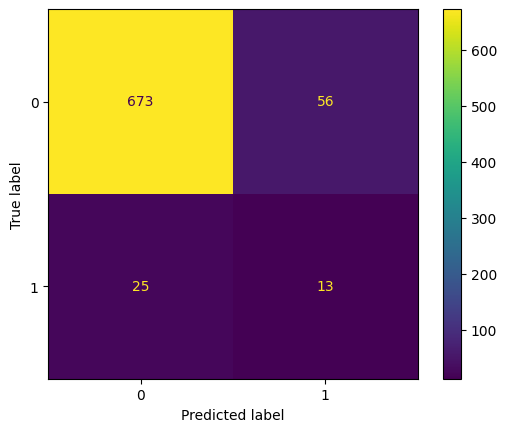

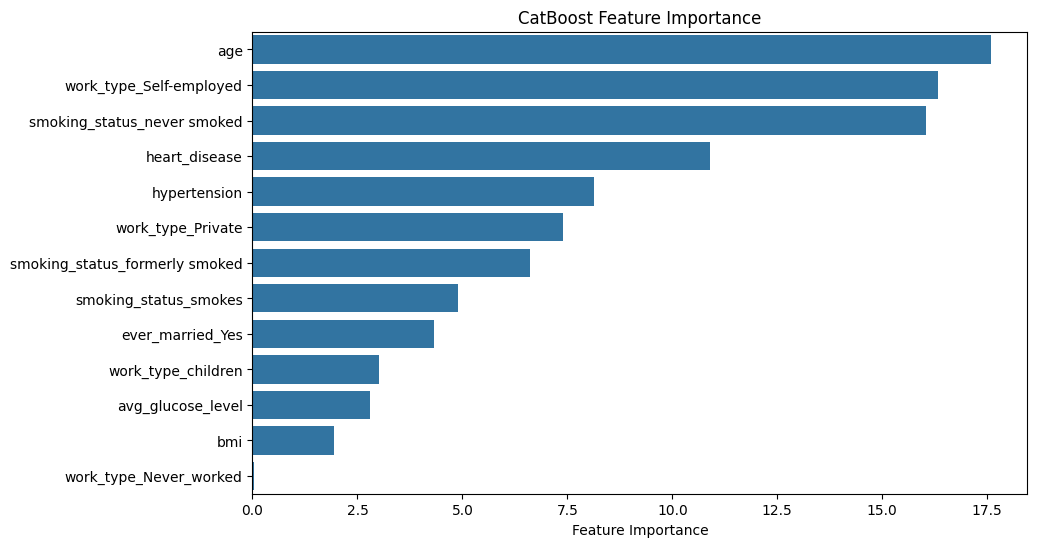

2025/05/27 18:20:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Successfully registered model 'CatBoostStrokePredictionModel'.
2025/05/27 18:20:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CatBoostStrokePredictionModel, version 1
Created version '1' of model 'CatBoostStrokePredictionModel'.


🏃 View run Final Model Training at: https://mlflow.spikehub.win/#/experiments/2/runs/05056e3e9d1647a3a30a761b9ab5c375
🧪 View experiment at: https://mlflow.spikehub.win/#/experiments/2


In [58]:
import mlflow.catboost
from sklearn.metrics import ConfusionMatrixDisplay

run_name = "Final Model Training"
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):
    best_model = CatBoostClassifier(**best_params, verbose=0)

    best_model.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=100,
        verbose=0,
    )

    y_test_pred = best_model.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    feature_importance = plot_feature_importance(best_model, X_train)

    mlflow.log_figure(confusion_matrix.figure_, "confusion_matrix.png")
    mlflow.log_figure(feature_importance, "feature_importance.png")

    mlflow.log_params(best_params)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow.set_tags(
        tags={
            "project": "stroke_prediction",
            "optimizer_engine": "optuna",
            "model_family": "catboost",
            "model_type": "classifier",
        }
    )

    signature = mlflow.models.infer_signature(X_train.iloc[0:5], best_model.predict(X_train.iloc[0:5]))

    mlflow.catboost.log_model(
        best_model,
        artifact_path="catboost_model",
        registered_model_name="CatBoostStrokePredictionModel",
        signature=signature,
        input_example=X_train.iloc[0:5],
    )